<a href="https://colab.research.google.com/github/alessandronicolini/IncrementalLearning/blob/main/Deepinversion%20di%20edo%20con%20batch%20shufflati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip3 install 'import_ipynb'
!pip3 install 'tqdm'
 
!rm -r IncrementalLearning
# upload work files from your git hub repository
import sys
 
!git clone https://github.com/alessandronicolini/IncrementalLearning.git # clone proj repository
!rm -rf IncrementalLearning/README.md 
!rm -rf IncrementalLearning/baselines.ipynb
 
path = 'IncrementalLearning/'
if path not in sys.path:
    sys.path.append('IncrementalLearning/')
 
!pip3 install import_ipynb

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 679 (delta 3), reused 0 (delta 0), pack-reused 667
Receiving objects: 100% (679/679), 1.45 MiB | 1.62 MiB/s, done.
Resolving deltas: 100% (404/404), done.


In [5]:
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import VisionDataset
from PIL import Image
import random
import torchvision
ROOT = './data'
class ilCIFAR100(VisionDataset):
    """
    Extends CIFAR100 class. Split the dataset into 10 batches, each one containing 10 classes.
    You can retrieve the batches from the attribute "batches", it has different structure according to
    test and train CIFAR100 splits:
        - train -> batches is a dictionary {0:{'train':indexes, 'val':indexes}...} 
        - test -> batches is a dictionary {0:indexes...}
    where the keys are the batch number.

    Args:
        root (string): Root directory of dataset where directory
            `cifar-10-batches-py` exists or will be saved to if download is set to True.
        seed(int): used to ensure reproducibility in shuffling operations.
        val_size(float, optional): between 0 and 1, fraction of data used for validation.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, `transforms.RandomCrop`
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    def __init__(self,classes_per_batch, seed, val_size=0.1, train=True, transform=None, target_transform=False, 
    download=True):
        
        super(ilCIFAR100, self).__init__(root=0)
        self.classes_per_batch=classes_per_batch

        
        self.__rs = seed # set random seed 
        self.train=train
        self.__transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])

        self.__transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])
        # if train:
        #     self.batches = self.__make_train_batches(val_size)
        # else:
        #     self.batches = self.__make_test_batches()
        if self.train == 'train':
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=True,
                                            download=True, transform=self.__transform_train)
        elif self.train == 'exemplars':
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=True,
                                            download=True, transform=self.__transform_test)
        else:
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=False,
                                        download=True, transform=self.__transform_test)
          
        self.targets = np.array(self.dataset.targets) # make targets an array to exploit masking
        random.seed(seed)
        self.classes = random.sample(range(0, 100), 100)
        #self.classes = self.classes.reshape((10, -1)) # each row contains the classes for the corrisponding batch
        #print(self.classes)
        self.__dictionary = {}
        for i, c in enumerate(self.classes):
          self.__dictionary[c] = i


    def get_dict(self):
      return self.__dictionary
    def __getitem__(self, index):
        return self.dataset.__getitem__(index)[0],self.dataset.__getitem__(index)[1]
    def __len__(self):
        return self.dataset.__len__()
    def getbatches(self):
      classlist=self.classes
      batches=[]
      for i in range(0,int(100/self.classes_per_batch)):
        #print(i)
        batch=classlist[int(i*self.classes_per_batch):int(i*10+self.classes_per_batch)]
        batches.append(batch)
      return batches
    def get_batch_indexes(self):
      classlist=self.classes
      numclass=self.classes_per_batch
      batch_indexes=[]
      for i in range(0,int(100/self.classes_per_batch)):
        batch=classlist[int(i*numclass):int(i*numclass+numclass)]
        mask=np.isin(self.targets,batch)
        indexes=np.array(np.arange(len(self.dataset.targets)))
        indexes=indexes[mask]
        batch_indexes.append(indexes)
      return batch_indexes
    def get_class_indexes(self,label):
      indexes = np.array(np.arange(len(self.dataset.targets)))
      labels = self.dataset.targets
      mask = np.isin(labels, label)
      indexes = indexes[mask]

      return indexes
    def get_train_val(self,valid):
      batches=self.get_batch_indexes()
      train=[]
      val=[]
      for batch in batches:
        #print(type(batch))
        random.shuffle(batch)
        valbatch=batch[0:int(valid*len(batch))]
        trainbatch=batch[int(valid*len(batch)):]
        train.append(trainbatch)
        val.append(valbatch)
      return train,val
import torch
import torch.optim as optim
import torchvision
import time
import os
import argparse
import numpy as np

def tensor2im(input_image, imtype=np.uint8):
    #CIFAR100
    mean = [0.5071, 0.4867, 0.4408] 
    std = [0.2675, 0.2565, 0.2761]
    #CIFAR10
    #mean = [0.4914, 0.4822, 0.4465]
    #std = [0.2023, 0.1994, 0.2010]
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor.cpu().detach().float().numpy()
        if image_numpy.shape[0] == 1:
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        for i in range(len(mean)): 
            image_numpy[i] = image_numpy[i] * std[i] + mean[i]
        image_numpy = image_numpy * 255
        image_numpy = np.transpose(image_numpy, (1, 2, 0))
    else:
        image_numpy = input_image
    return image_numpy.astype(imtype)

In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import math
from sklearn.preprocessing import normalize
import copy
import torchvision.datasets as dsets
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import Subset, DataLoader, Dataset
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

import import_ipynb
#from IncrementalLearning.cifar100 import ilCIFAR100

from google.colab import output
from IncrementalLearning.resnet_cifar import resnet32
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

importing Jupyter notebook from /content/IncrementalLearning/resnet_cifar.ipynb


In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import argparse
import random
import torch
import torch.nn as nn
# import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
# import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.transforms as transforms

import numpy as np
import os
import glob
import collections

#from resnet_cifar import ResNet34, ResNet18

try:
    from apex.parallel import DistributedDataParallel as DDP
    from apex import amp, optimizers
    USE_APEX = True
except ImportError:
    print("Please install apex from https://www.github.com/nvidia/apex to run this example.")
    print("will attempt to run without it")
    USE_APEX = False

#provide intermeiate information
debug_output = False
debug_output = True


class DeepInversionFeatureHook():
    '''
    Implementation of the forward hook to track feature statistics and compute a loss on them.
    Will compute mean and variance, and will use l2 as a loss
    '''

    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # hook co compute deepinversion's feature distribution regularization
        nch = input[0].shape[1]

        mean = input[0].mean([0, 2, 3])
        var = input[0].permute(1, 0, 2, 3).contiguous().view([nch, -1]).var(1, unbiased=False)

        # forcing mean and variance to match between two distributions
        # other ways might work better, e.g. KL divergence
        r_feature = torch.norm(module.running_var.data.type(var.type()) - var, 2) + torch.norm(
            module.running_mean.data.type(var.type()) - mean, 2)

        self.r_feature = r_feature
        # must have no output

    def close(self):
        self.hook.remove()

def get_images(net, bs=256, epochs=1000, idx=-1, var_scale=0.00005, competitive_scale=0.01,
               net_student=None, prefix=None, train_writer = None, global_iteration=None,
               use_amp=False, bn_reg_scale = 0.0,
               optimizer = None, inputs = None, labels = False, l2_coeff=0.0):
    '''
    Function returns inverted images from the pretrained model, parameters are tight to CIFAR dataset
    args in:
        net: network to be inverted
        bs: batch size
        epochs: total number of iterations to generate inverted images, training longer helps a lot!
        idx: an external flag for printing purposes: only print in the first round, set as -1 to disable
        var_scale: the scaling factor for variance loss regularization. this may vary depending on bs
            larger - more blurred but less noise
        net_student: model to be used for Adaptive DeepInversion
        prefix: defines the path to store images
        competitive_scale: coefficient for Adaptive DeepInversion
        train_writer: tensorboardX object to store intermediate losses
        global_iteration: indexer to be used for tensorboard
        use_amp: boolean to indicate usage of APEX AMP for FP16 calculations - twice faster and less memory on TensorCores
        optimizer: potimizer to be used for model inversion
        inputs: data place holder for optimization, will be reinitialized to noise
        bn_reg_scale: weight for r_feature_regularization
        random_labels: sample labels from random distribution or use columns of the same class
        l2_coeff: coefficient for L2 loss on input
    return:
        A tensor on GPU with shape (bs, 3, 32, 32) for CIFAR
    '''

    kl_loss = nn.KLDivLoss(reduction='batchmean').cuda()

    # preventing backpropagation through student for Adaptive DeepInversion
    net_student.train()

    best_cost = 1e6

    # initialize gaussian inputs
    #inputs.data = torch.tensor((bs, 3, 32, 32), requires_grad=True, device='cuda')
    inputs.data = inputs.to('cuda')

    # set up criteria for optimization
    criterion = nn.CrossEntropyLoss()

    optimizer.state = collections.defaultdict(dict)  # Reset state of optimizer

    # target outputs to generate
    #if labels:
    targets = labels
    #else:
     #   targets = torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * 25 + [0, 1, 2, 3, 4, 5]).to('cuda')

    outputs=net(inputs.data)
    _, predicted_teach = outputs.max(1)

    outputs_student=net_student(inputs.data)
    _, predicted_std = outputs_student.max(1)

    if idx == 0:
        print('Teacher correct out of {}: {}, loss at {}'.format(bs, predicted_teach.eq(targets).sum().item(), criterion(outputs, targets).item()))
        print('Student correct out of {}: {}, loss at {}'.format(bs, predicted_std.eq(targets).sum().item(), criterion(outputs_student, targets).item()))

    ## Create hooks for feature statistics catching
    loss_r_feature_layers = []
    for module in net.modules():
        if isinstance(module, nn.BatchNorm2d):
            loss_r_feature_layers.append(DeepInversionFeatureHook(module))

    # setting up the range for jitter
    lim_0, lim_1 = 2, 2

    for epoch in tqdm(range(epochs)):
        # apply random jitter offsets
        off1 = random.randint(-lim_0, lim_0)
        off2 = random.randint(-lim_1, lim_1)
        inputs_jit = torch.roll(inputs, shifts=(off1,off2), dims=(2,3))

        # foward with jit images
        optimizer.zero_grad()
        net.zero_grad()
        outputs = net(inputs_jit)
        loss = criterion(outputs, targets)
        loss_target = loss.item()

        # competition loss, Adaptive DeepInvesrion
        if competitive_scale != 0.0:
            net_student.zero_grad()
            outputs_student = net_student(inputs_jit)
            T = 3.0

            if 1:
                # jensen shanon divergence:
                # another way to force KL between negative probabilities
                P = F.softmax(outputs_student / T, dim=1)
                Q = F.softmax(outputs / T, dim=1)
                M = 0.5 * (P + Q)

                P = torch.clamp(P, 0.01, 0.99)
                Q = torch.clamp(Q, 0.01, 0.99)
                M = torch.clamp(M, 0.01, 0.99)
                eps = 0.0
                # loss_verifier_cig = 0.5 * kl_loss(F.log_softmax(outputs_verifier / T, dim=1), M) +  0.5 * kl_loss(F.log_softmax(outputs/T, dim=1), M)
                loss_verifier_cig = 0.5 * kl_loss(torch.log(P + eps), M) + 0.5 * kl_loss(torch.log(Q + eps), M)
                # JS criteria - 0 means full correlation, 1 - means completely different
                loss_verifier_cig = 1.0 - torch.clamp(loss_verifier_cig, 0.0, 1.0)

                loss = loss + competitive_scale * loss_verifier_cig

        # apply total variation regularization
        diff1 = inputs_jit[:,:,:,:-1] - inputs_jit[:,:,:,1:]
        diff2 = inputs_jit[:,:,:-1,:] - inputs_jit[:,:,1:,:]
        diff3 = inputs_jit[:,:,1:,:-1] - inputs_jit[:,:,:-1,1:]
        diff4 = inputs_jit[:,:,:-1,:-1] - inputs_jit[:,:,1:,1:]
        loss_var = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)
        loss = loss + var_scale*loss_var

        # R_feature loss
        loss_distr = sum([mod.r_feature for mod in loss_r_feature_layers])
        loss = loss + bn_reg_scale*loss_distr # best for noise before BN

        # l2 loss
        if 1:
            loss = loss + l2_coeff * torch.norm(inputs_jit, 2)

        if debug_output and epoch % 200==0:
            print(f"It {epoch}\t Losses: total: {loss.item():3.3f},\ttarget: {loss_target:3.3f} \tR_feature_loss unscaled:\t {loss_distr.item():3.3f}")
            #vutils.save_image(inputs.data.clone(),
             #                 './{}/output_{}.png'.format(prefix, epoch//200),
              #                normalize=True, scale_each=True, nrow=10)

        if best_cost > loss.item():
            best_cost = loss.item()
            best_inputs = inputs.data

        # backward pass
        if use_amp:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        optimizer.step()

    outputs=net(best_inputs)
    _, predicted_teach = outputs.max(1)

    outputs_student=net_student(best_inputs)
    _, predicted_std = outputs_student.max(1)

    if idx == 0:
        print('Teacher correct out of {}: {}, loss at {}'.format(bs, predicted_teach.eq(targets).sum().item(), criterion(outputs, targets).item()))
        print('Student correct out of {}: {}, loss at {}'.format(bs, predicted_std.eq(targets).sum().item(), criterion(outputs_student, targets).item()))

    name_use = "best_images"
    if prefix is not None:
        name_use = prefix + name_use
    next_batch = len(glob.glob("./%s/*.png" % name_use)) // 1

    #vutils.save_image(best_inputs[:20].clone(),
     #                 './{}/output_{}.png'.format(name_use, next_batch),
      #                normalize=True, scale_each = True, nrow=10)

    #if train_writer is not None:
     #   train_writer.add_scalar('gener_teacher_criteria', criterion(outputs, targets), global_iteration)
      #  train_writer.add_scalar('gener_student_criteria', criterion(outputs_student, targets), global_iteration)

       # train_writer.add_scalar('gener_teacher_acc', predicted_teach.eq(targets).sum().item() / bs, global_iteration)
       # train_writer.add_scalar('gener_student_acc', predicted_std.eq(targets).sum().item() / bs, global_iteration)

        #train_writer.add_scalar('gener_loss_total', loss.item(), global_iteration)
        #train_writer.add_scalar('gener_loss_var', (var_scale*loss_var).item(), global_iteration)

    net_student.train()

    return best_inputs

Please install apex from https://www.github.com/nvidia/apex to run this example.
will attempt to run without it


In [115]:
class mnemonics():
  def __init__(self, randomseed):
    self.device = 'cuda'
    self.model = resnet32(num_classes=100).to(self.device)
    self.feature_extractor = self.model.features
    self.temp_model = None
    self.lr = 2
    self.gamma = 0.2
    self.weight_decay = 1e-5 
    self.milestones = [49,63]
    self.batch_size = 128
    self.numepochs = 1
    self.n_classes = 0
    self.n_known = 0
    self.feature_size=64
    self.momentum=0.9
    self.criterion = nn.BCEWithLogitsLoss()

    self.NUM_BATCHES=10
    self.randomseed=randomseed
    self.trainloader=None
    self.testloader=None
    self.CLASSES_PER_BATCH=10

    self.original_training_set = ilCIFAR100(self.CLASSES_PER_BATCH, self.randomseed, train = 'train')
    self.original_exemplar_set = ilCIFAR100(self.CLASSES_PER_BATCH, self.randomseed, train = 'exemplars')
    self.original_test_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed, train= 'test')
    self.exloader=None
    self.last_test = None
    self.y_pred = []
    self.y_test = []

    self.cumulative_class_mean = []

    self.classes_seen=0
    self.diz = self.original_training_set.get_dict()

    self.fake_diz = {}
    for key, value in self.diz.items():
      self.fake_diz[value] = key


  def modification_of_random_exemplars(self, indexes, n_epochs):
    # CODICE PER CREARE LE IMMAGINI SINTETICHE, ORA ME LE CREO VOLTA PER VOLTA, QUINDI AD OGNI BATCH DIMENTICO QUELLE GIA FATTE E NE CREO NUOVE
    print('len of task:', len(indexes))

    inputs_dataset = torch.zeros((len(indexes),3,32,32))
    labels_of_modified = torch.zeros(len(indexes), dtype = int).to('cuda')

    for i, el in enumerate(indexes):
      inputs_dataset[i,:,:,:] = self.original_training_set.__getitem__(el)[0]
      labels_of_modified[i] = self.diz[self.original_training_set.__getitem__(el)[1]]


    number_of_images_created = len(indexes)

    teacher = copy.deepcopy(self.model)
    net_teacher = resnet32(num_classes=100).to('cuda')
    net_teacher.load_state_dict(teacher.state_dict())
    net_teacher.eval()

    net_student = resnet32(num_classes=100).to('cuda')
    #net_student = resnet18().to('cuda')

    self.model.eval()

    #inputs = torch.randn((number_of_images_created, 3, 32, 32), requires_grad=True, device='cuda', dtype=torch.float)
    
    #inputs_dataset = torch.tensor(inputs_dataset.data, requires_grad=True, dtype = torch.float, device = 'cuda')

    train_writer = None  # tensorboard writter
    global_iteration = 0
    di_lr = 0.05
    optimizer_di = optim.Adam([inputs_dataset], lr=di_lr)
    #plt.imshow(tensor2im(inputs_dataset[0]))
    #plt.show()
    print("Starting model inversion")
    batch_idx = 0
    '''
    inputs = get_images(net=net_teacher, bs=len(labels_of_modified), epochs=n_epochs, idx=batch_idx, 
                      net_student=net_student, competitive_scale=10.0, l2_coeff = 3e-8, bn_reg_scale = 1.0,
                      train_writer=train_writer, use_amp=False,
                      optimizer=optimizer_di, inputs=inputs_dataset, 
                      var_scale=2e-5, labels=labels_of_modified) #2.5e-5
    '''
    #plt.imshow(tensor2im(inputs[0]))
    #plt.show()
    print('deepinversion finshed')
    #output.clear()
    #inputs_data = torch.tensor(inputs, requires_grad=False).cpu()
    labels = torch.tensor([self.fake_diz[c.item()] for c in labels_of_modified])
    return inputs_dataset, labels

  def model_level_optimization(self):
    
    old_model = copy.deepcopy(self.model)
    old_model.eval()
    old_model.to(self.device)
    n_classes = self.classes_seen+self.CLASSES_PER_BATCH
    print(n_classes)
    optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)
    #if self.exloader is None:
    for epoch in tqdm(range(self.numepochs)):
      pino=0  
      for inputs, labels in self.trainloader:
        inputs = inputs.float().to(self.device)
        labels = torch.tensor([self.diz[c.item()] for c in labels])
        pino+=1
        labels=labels.to(self.device)
        optimizer.zero_grad()
        outputs=self.model(inputs)

        labels_encoded = F.one_hot(labels,100).float().to(self.device)
        
        loss = self.criterion(outputs, labels_encoded) 
        loss.backward()
        optimizer.step()
      
      scheduler.step()
    '''
    else:
      count = 0
      for epoch in tqdm(range(self.numepochs)):
        for pd in range(len(self.trainloadlistlab)):
          #
          try:
            inputs=torch.cat((self.trainloadlist[pino],self.exloadlist[pino]))
            labels=torch.cat((self.trainloadlistlab[pino],self.exloadlistlab[pino]))
            count+=len(labels)
          except:
            print('porcodio except')
            #cazzo = len(self.trainloadlist)
            #inputs=self.trainloadlist[cazzo]
            #labels=self.trainloadlistlab[cazzo]
          #
          inputs = self.oo[pd,:,:,:,:]
          labels = self.oi[pd,:]
          inputs = inputs.float().to(self.device)
          labels = torch.tensor([self.diz[c.item()] for c in labels])
          
          for i in labels:
            if i <= 9:
              count+=1
          labels=labels.to(self.device)
          optimizer.zero_grad()
          outputs=self.model(inputs)

          labels_encoded = F.one_hot(labels,100).float().to(self.device) 
          

          old_target = old_model(inputs).to(self.device)
          old_target = torch.sigmoid(old_target).to(self.device)
          
          target = torch.cat((old_target[:,:self.classes_seen], labels_encoded[:, self.classes_seen:]), dim=1)
          loss = self.criterion(outputs, target) 

          loss.backward()
          optimizer.step()
        scheduler.step()
        print(count)
     '''

  def classify_nme(self, input_batch):
    min_distances = float('inf')*torch.ones(len(input_batch)).to(self.device) # shape: batch_size --> 128
    y_pred = torch.zeros(len(input_batch), dtype=torch.int8).to(self.device) # shape: batch_size --> 128
    input_features = self.model.features(input_batch) # shape: (batch_size, feature_size) --> (128, 64)

    for i in range(len(self.exemplar_sets_idxs)):
      ex_mean = self.exemplar_means[i,:]

      # compute distances between inputs features and exemplar set means
      pdist = nn.PairwiseDistance(p=2)
      distances = pdist(input_features, ex_mean) # shape: batch_size --> 128

      # update min distancies and predicted labels
      mask = distances < min_distances
      min_distances[mask] = distances[mask]
      y_pred[mask] = self.exemplar_labels[i]

    return y_pred
    


  def get_new_exemplars(self, batch, m):
    loader = torch.utils.data.DataLoader(batch, batch_size=self.batch_size,shuffle=False, num_workers=4)
    features = np.zeros((0,self.feature_size))
    indices = np.zeros((0), dtype=int)
    with torch.no_grad():
      for indexes, images, labels in loader:
        images = images.cuda()
        feature = self.feature_extractor(images).data.cpu().numpy()
        feature = normalize(feature, axis=1, norm='l2')
        features = np.concatenate((features,feature), axis=0)
        indices = np.concatenate((indices,indexes), axis=0)

    class_mean = np.mean(features, axis=0)
    class_mean = class_mean / np.linalg.norm(class_mean)  # Normalize

    #self.cumulative_class_mean.append(class_mean)

    exemplar_set = []
    exemplar_features = np.zeros((0,self.feature_size))

    for k in range(1, int(m)+1):
        S = np.sum(exemplar_features, axis=0)
        phi = features
        mu = class_mean
        mu_p = 1.0 / k * (phi + S)
        mu_p = normalize(mu_p, axis=1, norm='l2')
        i = np.argmin(np.sqrt(np.sum((mu - mu_p) ** 2, axis=1)))
        exemplar_set.append(int(indices[i]))
        addfeature =  np.expand_dims(features[i], axis=0)
        exemplar_features = np.concatenate((exemplar_features,addfeature), axis=0)

        #remove duplicates
        features = np.delete(features, i, 0)
        indices = np.delete(indices, i, 0)
        
    self.exemplar_sets_idxs.append(exemplar_set)
    #self.exemplar_sets_idxs.append(random.sample(list(batch), m))


  def reduce_old_exemplars(self, m):
    for i, set_i in enumerate(self.exemplar_sets_idxs):
      self.exemplar_sets_idxs[i] = random.sample(set_i, m)

  def __accuracy_fc(self, dl, mapper):
    total = 0.0
    correct = 0.0
    for images, labels in dl:
      labels = torch.tensor([torch.tensor(mapper[c.item()]) for c in labels])
      labels = labels.to(self.device)
      images = images.to(self.device)
      outputs = self.model(images)
      _, preds = torch.max(outputs, dim=1)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

    acc = correct / total
    return acc


  def __accuracy_nme(self, dl):
    
    total = 0.0
    correct = 0.0
    
    for  _, images, labels in dl:
      labels = labels.to(self.device)
      images = images.to(self.device)
      preds = self.classify_nme(images)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

      if self.last_test:
        self.y_pred += preds.tolist()
        self.y_test += labels.tolist()

    acc = correct / total
    return acc


  def plot_confusion_matrix(self):
 
    cm = confusion_matrix(self.y_test, self.y_pred)
    cm = np.log(cm+1)
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cm, square=True, cbar=False, ax=ax, cmap=plt.get_cmap('seismic'))
    ax.set_xticks(np.linspace(19,99,5))
    ax.set_yticks(np.linspace(19,99,5))
    ax.set_xticklabels([20,40,60,80,100], rotation=0)
    ax.set_yticklabels([20,40,60,80,100], rotation=0)
    ax.set_title("iCaRL")
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    plt.savefig("iCaRL_"+str(self.randomseed)+"_cm.png")
    plt.show()
    return cm

  def plot_data(self, train_dl):

    from sklearn.manifold import TSNE
    print('------plot data------')

    #Data points
    train_labels_array = torch.zeros(0).to('cuda')
    train_dataset_to_reduce = np.zeros((0,64), dtype = float)

    for  _, images, labels in train_dl:
      labels = labels.to(self.device)
      images = images.to(self.device)
      train_dataset_to_reduce = np.concatenate((train_dataset_to_reduce, self.feature_extractor(images).cpu().detach().numpy()))
      train_labels_array = torch.cat((train_labels_array, labels))

    
    #EX e MN loaders 
    current_exemplar_indices = np.array([], dtype=int)

    for exemplar_set in self.exemplar_sets_idxs:
      current_exemplar_indices = np.concatenate([current_exemplar_indices, np.array(exemplar_set)])

    exemplar_dataset = Subset(self.original_training_set, current_exemplar_indices)
    ex_dl = DataLoader(exemplar_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, drop_last=True) #usato solo per plottare

    mn_dataset = Subset(self.original_exemplar_set, current_exemplar_indices)
    mn_dl = DataLoader(mn_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, drop_last=True) #usato solo per plottare


    #Exemplars

    ex_labels_array = torch.zeros(0).to('cuda')
    ex_dataset_to_reduce = np.zeros((0,64), dtype = float)

    for  _, images, labels in ex_dl:
      labels = labels.to(self.device)
      images = images.to(self.device)
      ex_dataset_to_reduce = np.concatenate((ex_dataset_to_reduce, self.feature_extractor(images).cpu().detach().numpy()))
      ex_labels_array = torch.cat((ex_labels_array, labels), dim = 0)


    #Mnemonics


    mn_labels_array = torch.zeros(0).to('cuda')
    mn_dataset_to_reduce = np.zeros((0,64), dtype = float)

    for  _, images, labels in mn_dl:
      labels = labels.to(self.device)
      images = images.to(self.device)
      mn_dataset_to_reduce = np.concatenate((mn_dataset_to_reduce, self.feature_extractor(images).cpu().detach().numpy()))
      mn_labels_array = torch.cat((mn_labels_array, labels), dim = 0)

    #PLOT'''
    total_data_w_exemplars = np.concatenate((train_dataset_to_reduce, ex_dataset_to_reduce))
    total_data_w_mn =  np.concatenate((train_dataset_to_reduce, mn_dataset_to_reduce))

    total_transformed_ex = TSNE(n_components=2).fit_transform(total_data_w_exemplars)
    X_transformed_w_ex = total_transformed_ex[:train_dataset_to_reduce.shape[0]]
    ex_transformed = total_transformed_ex[train_dataset_to_reduce.shape[0]:]

    total_transformed_mn = TSNE(n_components=2).fit_transform(total_data_w_mn)
    X_transformed_w_mn = total_transformed_mn[:train_dataset_to_reduce.shape[0]]
    mn_transformed = total_transformed_mn[train_dataset_to_reduce.shape[0]:]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,12))
    ax1.scatter(X_transformed_w_ex[:,0], X_transformed_w_ex[:,1], c = train_labels_array.cpu(), alpha = 0.1)
    ax1.scatter(ex_transformed[:,0], ex_transformed[:,1], c = ex_labels_array.cpu(), alpha = 1)
    #ax1.title('EXEMPLARS')

    ax2.scatter(X_transformed_w_mn[:,0], X_transformed_w_mn[:,1], c = train_labels_array.cpu(), alpha = 0.1)
    ax2.scatter(mn_transformed[:,0], mn_transformed[:,1], c = mn_labels_array.cpu(), alpha = 1)
    #ax2.title('MNEMONICS')
    plt.show()

  def trainer(self):
    
    train_indices = self.original_training_set.get_batch_indexes()
    test_indices = self.original_test_set.get_batch_indexes()
    batches=self.original_training_set.getbatches()
    current_test_indexes=[]
    test_acc = []
    incremental_classes_label = np.array([])
    self.last_test = False

    n_epochs = 100 #NUMERO DI ITERAZIONI PER GENERARE IMMAGINI

    for i in range(self.NUM_BATCHES):

      if i == self.NUM_BATCHES-1:
        self.last_test = True
     
      train_dataset = Subset(self.original_training_set, train_indices[i])
      current_test_indexes += test_indices[i].tolist()
      test_dataset = Subset(self.original_test_set,current_test_indexes)
      self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, drop_last=True)
      self.testloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, drop_last=True)      

      #self.exloadlist=[]
      #self.exloadlistlab=[]
      if i == 0:
        self.trainloader = self.train_loader
      else:
        #totalset=torch.utils.data.ConcatDataset((train_dataset, porcoddio))

        self.exloader= DataLoader(exset, batch_size=37, shuffle=True, num_workers=4, drop_last = True)
        self.trainloader = DataLoader(train_dataset, batch_size=91, shuffle=True,num_workers=4, drop_last = True)#, num_workers=4, pin_memory=True)
        #max_ = max(len(self.exloader), len(self.trainloader))
        #print('max', max)
        self.trainloadlist=torch.zeros((len(self.trainloader), 128, 3, 32, 32))
        self.trainloadlistlab=torch.zeros((len(self.trainloader), 128), dtype = int)
  
        #for n_b in range(max):
        for zz, (im, lab) in enumerate(self.trainloader):
          self.trainloadlist[zz, :91, :, :, :] = im
          self.trainloadlistlab[zz, :91] = lab

        for zz, (im,lab) in enumerate(self.exloader):
          self.trainloadlist[zz, 91:, :, :, :] = im
          self.trainloadlistlab[zz, 91:] = lab
        
        self.oo = torch.zeros((len(self.trainloader), 128, 3, 32, 32))
        self.oi = torch.zeros((len(self.trainloader), 128), dtype = int)

        for zz in  range(len(self.trainloadlist)):
          permutations = torch.randperm(128) 
          for y, el in enumerate(permutations):
            self.oo[zz, y, :, :, :] = self.trainloadlist[zz, int(el), :, :, :]
            self.oi[zz, y] = self.trainloadlistlab[zz, int(el)]

      self.model.train()
      self.model_level_optimization()    
      self.classes_seen += 10
      self.model.eval() # Set Network to evaluation mode

      print('accuracy on training set:', 100*self.__accuracy_fc(self.trainloader,self.diz))
      if i!=0:
        print('accuracy on exemplars set:', 100*self.__accuracy_fc(self.exloader,self.diz))
      # print('accuracy on test set:', self.__accuracy_on(self.testloader,self,self.diz))
      current_test_acc = self.__accuracy_fc(self.testloader, self.diz)
      print('accuracy on test set:', 100*current_test_acc)

      m=int(2000/(int(i*10+10)))

      max_number_to_generate = 666 #round(666/..)
      incremental_classes_label = np.concatenate((incremental_classes_label, batches[i]))
      actual_number_of_images_per_classes_generate = int(max_number_to_generate/len(incremental_classes_label))

      images_task_1 = np.array([], dtype = int)
      images_task_2 = np.array([], dtype = int)
      images_task_3 = np.array([], dtype = int)

      for i in incremental_classes_label:
        random_images = random.sample(list(self.original_training_set.get_class_indexes(i)), m)
        images_task_1 = np.concatenate((images_task_1, random_images[:int(m/3)]))
        images_task_2 = np.concatenate((images_task_2, random_images[int(m/3):2*(int(m/3))]))
        images_task_3 = np.concatenate((images_task_3, random_images[2*(int(m/3)):]))

      task_1, labels_1 = self.modification_of_random_exemplars(images_task_1, n_epochs)
      task_2, labels_2 = self.modification_of_random_exemplars(images_task_2, n_epochs)
      task_3, labels_3 = self.modification_of_random_exemplars(images_task_3, n_epochs)

      syntetic_exemplars = torch.cat((task_1, task_2, task_3), dim = 0)
      syntetic_labels = torch.cat((labels_1, labels_2, labels_3))
      exset = torch.utils.data.TensorDataset(syntetic_exemplars, syntetic_labels)
      
        
      # reduce the number of each exemplars set
      #self.reduce_old_exemplars(m) 

      #self.cumulative_class_mean = {}

      print('-' * 80)
      test_acc.append(current_test_acc)

In [116]:
method = mnemonics(randomseed=203)
model, batch = method.trainer()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
10



accuracy on training set: 31.490384615384613
accuracy on test set: 35.044642857142854
len of task: 660
Starting model inversion
deepinversion finshed
len of task: 660
Starting model inversion
deepinversion finshed
len of task: 680
Starting model inversion
deepinversion finshed
--------------------------------------------------------------------------------
20



accuracy on training set: 20.81807081807082
accuracy on exemplars set: 0.0
accuracy on test set: 9.427083333333334
len of task: 660
Starting model inversion
deepinversion finshed
len of task: 660
Starting model inversion
deepinversion finshed
len of task: 680
Starting model inversion
deepinversion finshed
--------------------------------------------------------------------------------


KeyboardInterrupt: ignored

In [ ]:
ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[1]

Files already downloaded and verified


array([    9,    12,    14, ..., 49981, 49988, 49991])

In [ ]:
# PER IMPORTARE RESNET 18 34 e 50
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git

! cp -r /content/PyTorch_CIFAR10/cifar10_models/resnet.py /content

!pip install pytorch_lightning
#!python /content/PyTorch_CIFAR10/train.py --download_weights 1

! cp -r /content/cifar10_models/state_dicts /content

#DOPO AVER IMPORTATO IL CONTENUTO DEL TIPO, SCEGLOERE LA RETE CHE SI VUOLE
from resnet import resnet50, resnet18, resnet34

trials = resnet34(pretrained = False).to('cuda')

In [ ]:
training_dataset = ilCIFAR100(10, 203, train = 'train')
diz = training_dataset.get_dict()

Files already downloaded and verified


In [ ]:
#QUI CREO E ALLENO LA SECONDA RESNET CON CUI POI MI MODIFICO LE IMMAGINI
train_dataset1 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset2 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset3 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset4 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])


train_dataset = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)
test_dataset = Subset(ilCIFAR100(10, 203, train = 'test'), ilCIFAR100(10, 203, train = 'test').get_batch_indexes()[0])
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, drop_last=True)
fake_model = resnet32(num_classes=10).to('cuda')

fake_model.train()

optimizer = optim.SGD(fake_model.parameters(), lr=2, momentum=0.9, weight_decay= 1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[49,63], gamma=0.2)
criterion = nn.BCEWithLogitsLoss()

tt = DataLoader(torch.utils.data.ConcatDataset((train_dataset1, train_dataset2, train_dataset3, train_dataset4)), batch_size=128, shuffle=True, num_workers=4)

for epoch in tqdm(range(70)):
  tot_loss = 0.0 
  for _, inputs, labels in train_loader:
    inputs = inputs.float().to('cuda')
    labels = torch.tensor([diz[c.item()] for c in labels])

    labels=labels.to('cuda')
    optimizer.zero_grad()
    outputs=fake_model(inputs)

    labels_encoded = F.one_hot(labels, 10).float().to('cuda') #CAMBIARE ONE_HOT
    loss = criterion(outputs, labels_encoded) 

    loss.backward()
    optimizer.step()
    tot_loss+=loss.item()
  scheduler.step()
  print(f'loss at epoch {epoch}', tot_loss)

fake_model.eval()
total = 0.0
correct = 0.0
for  _, images, labels in test_loader:
  labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
  labels = labels.to('cuda')
  images = images.to('cuda')
  outputs = fake_model(images)
  _, preds = torch.max(outputs, dim=1)
  total += len(labels)
  correct += torch.sum(preds == labels).item()

acc = correct / total
print('test accuracy of temporary resnet', acc)

In [ ]:
#RICAVO 200 IMMAGINI CASUALI, 20 PER CLASSE
labels_of_modified = torch.zeros(200, dtype = int).to('cuda')
inputs_dataset = torch.zeros((200,3,32,32))
my_class_indexes = np.array([], dtype = int)
for i in training_dataset.getbatches()[0]:
  ii = random.sample(list(training_dataset.get_class_indexes(i)), 20)
  my_class_indexes = np.concatenate((my_class_indexes, ii))
for i, el in enumerate(my_class_indexes):
  inputs_dataset[i,:,:,:] = training_dataset.__getitem__(el)[1]
  labels_of_modified[i] = diz[training_dataset.__getitem__(el)[2]]
#inputs_loader = train_dataset = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train  'train').get_batch_indexes()[0])

In [ ]:
labels_of_modified

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


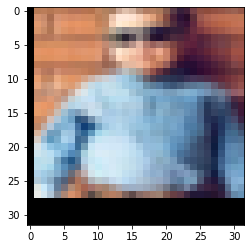

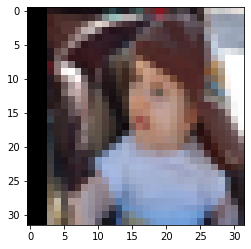

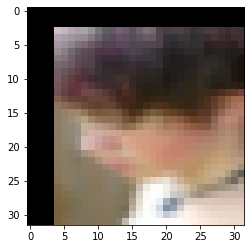

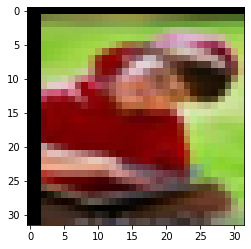

Starting model inversion
Teacher correct out of 200: 199, loss at 0.021377451717853546
Student correct out of 200: 4, loss at 4.754897594451904


It 0	 Losses: total: 19.107,	target: 0.021 	R_feature_loss unscaled:	 13.689
It 200	 Losses: total: 14.043,	target: 0.024 	R_feature_loss unscaled:	 8.813
It 400	 Losses: total: 17.877,	target: 0.001 	R_feature_loss unscaled:	 12.986

Teacher correct out of 200: 197, loss at 0.04932146146893501
Student correct out of 200: 1, loss at 4.781916618347168


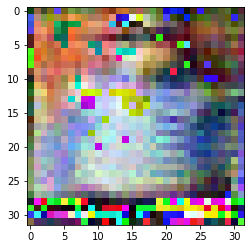

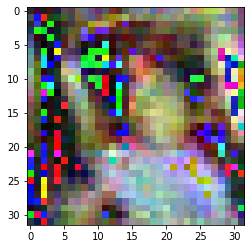

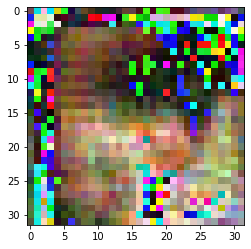

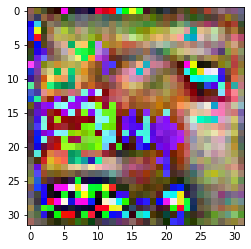

deepinversion finshed


In [ ]:
# CODICE PER CREARE LE IMMAGINI SINTETICHE
number_of_images_created = 200

teacher = copy.deepcopy(model)
net_teacher = resnet32(num_classes=100).to('cuda')
net_teacher.load_state_dict(teacher.state_dict())
net_teacher.eval()

net_student = resnet32(num_classes=100).to('cuda')
#net_student = resnet18().to('cuda')

model.eval()

#inputs = torch.randn((number_of_images_created, 3, 32, 32), requires_grad=True, device='cuda', dtype=torch.float)
inputs_dataset = torch.tensor(inputs_dataset.data, requires_grad=True, dtype = torch.float, device = 'cuda')

train_writer = None  # tensorboard writter
global_iteration = 0
di_lr = 0.05
optimizer_di = optim.Adam([inputs_dataset], lr=di_lr)
plt.imshow(tensor2im(inputs_dataset[0]))
plt.show()
plt.imshow(tensor2im(inputs_dataset[1]))
plt.show()
plt.imshow(tensor2im(inputs_dataset[2]))
plt.show()
plt.imshow(tensor2im(inputs_dataset[3]))
plt.show()
print("Starting model inversion")
batch_idx = 0
inputs = get_images(net=net_teacher, bs=len(labels_of_modified), epochs=600, idx=batch_idx, 
                  net_student=net_student, competitive_scale=10.0, l2_coeff = 3e-8, bn_reg_scale = 1.0,
                  train_writer=train_writer, use_amp=False,
                  optimizer=optimizer_di, inputs=inputs_dataset, 
                  var_scale=2e-5, labels=labels_of_modified) #2.5e-5
#trials.eval()
plt.imshow(tensor2im(inputs[0]))
plt.show()
plt.imshow(tensor2im(inputs[1]))
plt.show()
plt.imshow(tensor2im(inputs[2]))
plt.show()
plt.imshow(tensor2im(inputs[3]))
plt.show()
print('deepinversion finshed')

In [ ]:
#IN MODO DA AVERE UN DIZIONARIO UNICO PER IL FINETUNING SINTETICI + IMMAGINI
fake_diz = {0:11, 1:5, 2:62, 3:76, 4:27, 5:3, 6:96, 7:33, 8:78, 9:30}
labels_of_modified = torch.tensor([fake_diz[c.item()] for c in labels_of_modified]).to('cuda')

In [ ]:
# CREO UN DATALOADER UNICO CON DATI+IMMAGINI SINTETICHE
inputs_data = torch.tensor(inputs, requires_grad=False).cpu()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)

porcoddio = torch.utils.data.TensorDataset(torch.randn(len(inputs.data), requires_grad=False).cpu(), inputs_data, labels_of_modified.cpu())
porcoddiol = DataLoader(porcoddio, batch_size = 128, shuffle=False, drop_last=False)#, num_workers=4, drop_last=False) #A SECONDA DEL BATCH

tt = DataLoader(torch.utils.data.ConcatDataset((train_dataset, porcoddio)), batch_size=128, shuffle=False)#, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, drop_last=False)

for param in model.parameters():
  param.requires_grad = False

model.train('False')
correct = 0.0
total = 0.0
for _, image, label in porcoddiol:
  labels = torch.tensor(torch.tensor([diz[c.item()] for c in label]))
  labels = labels.to('cuda')
  image = image.to('cuda')
  outputs = model(image)
  _, preds = torch.max(outputs, dim=1)
  total += len(labels)
  correct += torch.sum(preds == labels).item()

acc = correct / total
model.train('False')
print('test accuracy data + syntetic exemplars', acc, total)


test accuracy data + syntetic exemplars 0.925 200.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
#PER VERIFICARE COME LA NOSTRA RETE CLASSIFICA LE IMMAGINI SINTETICHE
#trials.eval()

total = 200.0
correct = 0.0

label = torch.tensor([torch.tensor(diz[c.item()]) for c in labels_of_modified]).to('cuda')
outputs = model(inputs.data)
_, preds = torch.max(outputs, dim=1)
correct += torch.sum(preds == label).item()
#total += len(label)
acc = correct / total
print('test accuracy only syntetic exemplars', acc)

test accuracy only syntetic exemplars 0.995


In [ ]:
#ALLENO UN MODELLO DA ZERO CON DATI+EXEMPLAR SINTETICI
#tt = DataLoader(torch.utils.data.ConcatDataset((train_dataset, porcoddio)), batch_size=128, shuffle=True)#, num_workers=4, pin_memory=True)
train_dataset = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, drop_last=True)
fake_model = resnet32(num_classes=100).to('cuda')
fake_model.train()

optimizer = optim.SGD(fake_model.parameters(), lr=2, momentum=0.9, weight_decay= 1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[49,63], gamma=0.2)
criterion = nn.BCEWithLogitsLoss()

for epoch in tqdm(range(70)):
  tot_loss = 0.0 
  for _, inputs, labels in tt:
    inputs = inputs.float().to('cuda')
    labels = torch.tensor([diz[c.item()] for c in labels])

    labels=labels.to('cuda')
    optimizer.zero_grad()
    outputs=fake_model(inputs)

    labels_encoded = F.one_hot(labels, 100).float().to('cuda') #CAMBIARE ONE_HOT
    loss = criterion(outputs, labels_encoded) 

    loss.backward()
    optimizer.step()
    tot_loss+=loss.item()
  scheduler.step()
  print(f'loss at epoch {epoch}', tot_loss)
fake_model.eval()

total = 0.0
correct = 0.0
for  _, images, labels in test_loader:
  labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
  labels = labels.to('cuda')
  images = images.to('cuda')
  outputs = fake_model(images)
  _, preds = torch.max(outputs, dim=1)
  total += len(labels)
  correct += torch.sum(preds == labels).item()

acc = correct / total
print('test accuracy with syntetic exemplars', acc)

Files already downloaded and verified
Files already downloaded and verified


loss at epoch 0 2.4540810100734234
loss at epoch 1 0.9700034447014332
loss at epoch 2 0.8656038641929626
loss at epoch 3 0.785343898460269
loss at epoch 4 0.7194453729316592
loss at epoch 5 0.6722258748486638
loss at epoch 6 0.6303174179047346
loss at epoch 7 0.5516120810061693
loss at epoch 8 0.4870914202183485
loss at epoch 9 0.43468355666846037
loss at epoch 10 0.42519158590584993
loss at epoch 11 0.4045130517333746
loss at epoch 12 0.39306805515661836
loss at epoch 13 0.3057033601216972
loss at epoch 14 0.24645023792982101
loss at epoch 15 0.25532248336821795
loss at epoch 16 0.2748253480531275
loss at epoch 17 0.2523432490415871
loss at epoch 18 0.19916161010041833
loss at epoch 19 0.17305954755283892
loss at epoch 20 0.1533484470564872
loss at epoch 21 0.13120939279906452
loss at epoch 22 0.10854474175721407
loss at epoch 23 0.07234471826814115
loss at epoch 24 0.053358428238425404
loss at epoch 25 0.03999096667394042
loss at epoch 26 0.029273440944962204
loss at epoch 27 0.02165

In [ ]:

#ALLENO UN MODELLO DA ZERO CON SOLO I DATI E CONFRONTO I RISULTATI CON QUELLI PRECEDENTI (PORCODIO)
train_dataset1 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset2 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset3 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset4 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset5 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset6 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset7 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset8 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset9 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset10 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset11 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset12 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset13 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset14 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
train_dataset15 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset16 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset17 = Subset(ilCIFAR100(10, 203, train = 'exemplars'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset18 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset19 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset20 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset21 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset22 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset23 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset24 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset25 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset26 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
##train_dataset27 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset28 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset29 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])
#train_dataset30 = Subset(ilCIFAR100(10, 203, train = 'train'), ilCIFAR100(10, 203, train = 'train').get_batch_indexes()[0])

#tt = DataLoader(torch.utils.data.ConcatDataset((train_dataset1, train_dataset16, train_dataset17, train_dataset12, train_dataset11,
#                                                train_dataset26, train_dataset27, train_dataset28, train_dataset29, train_dataset30, 
 #                                               train_dataset15, train_dataset13, train_dataset14, train_dataset2, train_dataset3, train_dataset4, 
  #                                              train_dataset18, train_dataset19, train_dataset20, train_dataset21, train_dataset22, train_dataset23, train_dataset24, train_dataset25,
   #                                             train_dataset5, train_dataset6, train_dataset7, train_dataset8, train_dataset9, train_dataset10)), batch_size=128, shuffle=True, num_workers=4)

tt = DataLoader(torch.utils.data.ConcatDataset((train_dataset1, train_dataset12, train_dataset11, train_dataset2, train_dataset3, train_dataset4, 
                                                train_dataset15, train_dataset13, train_dataset14,
                                                train_dataset5, train_dataset6, train_dataset7, train_dataset8, train_dataset9, train_dataset10)), batch_size=128, shuffle=True, num_workers=4)

#train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)
test_dataset = Subset(ilCIFAR100(10, 203, train = 'test'), ilCIFAR100(10, 203, train = 'test').get_batch_indexes()[0])
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, drop_last=True)
fake_model = resnet32(num_classes=10).to('cuda')

fake_model.train()

optimizer = optim.SGD(fake_model.parameters(), lr=2, momentum=0.9, weight_decay= 1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[49,63], gamma=0.2)
#USO PARAMETRI DELLO STRONZO https://github.com/chenyaofo/CIFAR-pretrained-models
#optimizer = torch.optim.SGD(fake_model.parameters(), lr=0.1, momentum=0.9, dampening=0, weight_decay=1e-4, nesterov=True)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200,eta_min=0.001)
criterion = nn.BCEWithLogitsLoss()


for epoch in tqdm(range(70)):
  tot_loss = 0.0 
  for _, inputs, labels in tt:
    inputs = inputs.float().to('cuda')
    labels = torch.tensor([diz[c.item()] for c in labels])

    labels=labels.to('cuda')
    optimizer.zero_grad()
    outputs=fake_model(inputs)

    labels_encoded = F.one_hot(labels, 10).float().to('cuda') #CAMBIARE ONE_HOT
    loss = criterion(outputs, labels_encoded) 

    loss.backward()
    optimizer.step()
    tot_loss+=loss.item()
  scheduler.step()
  print(f'loss at epoch {epoch}', tot_loss)

fake_model.eval()
total = 0.0
correct = 0.0
for  _, images, labels in test_loader:
  labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
  labels = labels.to('cuda')
  images = images.to('cuda')
  outputs = fake_model(images)
  _, preds = torch.max(outputs, dim=1)
  total += len(labels)
  correct += torch.sum(preds == labels).item()

acc = correct / total
print('test accuracy without syntetic exemplars', acc)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

loss at epoch 0 155.66958345472813
loss at epoch 1 106.21544831246138
loss at epoch 2 66.52168030664325
loss at epoch 3 39.8606150764972
loss at epoch 4 25.79490514099598
loss at epoch 5 19.613789472728968
loss at epoch 6 16.38592846877873
loss at epoch 7 15.017129165120423
loss at epoch 8 12.710098922252655
loss at epoch 9 12.057295091915876
loss at epoch 10 10.684321078239009
loss at epoch 11 10.166169221745804
loss at epoch 12 9.790142235113308
loss at epoch 13 9.240282169310376
loss at epoch 14 8.96785125718452
loss at epoch 15 8.60802650032565
loss at epoch 16 8.716180350398645
loss at epoch 17 7.479629223933443
loss at epoch 18 7.157237049774267
loss at epoch 19 8.09359107608907
loss at epoch 20 7.2845343597000465
loss at epoch 21 7.347161765675992
loss at epoch 22 6.393910889397375
loss at epoch 23 7.16034741490148
loss at epoch 24 6.593653330346569
loss at epoch 25 6.57824734330643
loss at epoch 26 7.173188903136179
loss at epoch 27 5.8460842167260125
loss at epoch 28 6.5470650

len to be created 200


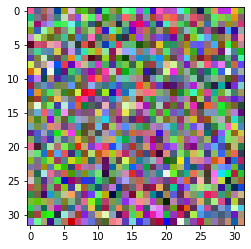

Starting model inversion
Teacher correct out of 200: 20, loss at 30.005359649658203
Student correct out of 200: 14, loss at 2.4516043663024902


It 0	 Losses: total: 2361.869,	target: 29.826 	R_feature_loss unscaled:	 465.511
It 200	 Losses: total: 149.167,	target: 1.529 	R_feature_loss unscaled:	 28.341
It 400	 Losses: total: 129.996,	target: 0.756 	R_feature_loss unscaled:	 24.695
It 600	 Losses: total: 95.059,	target: 0.330 	R_feature_loss unscaled:	 17.851
It 800	 Losses: total: 145.979,	target: 0.206 	R_feature_loss unscaled:	 28.090
It 1000	 Losses: total: 84.140,	target: 0.172 	R_feature_loss unscaled:	 15.727
It 1200	 Losses: total: 101.684,	target: 0.137 	R_feature_loss unscaled:	 19.280
It 1400	 Losses: total: 69.189,	target: 0.068 	R_feature_loss unscaled:	 12.837

Teacher correct out of 200: 195, loss at 0.09391734004020691
Student correct out of 200: 2, loss at 2.774430274963379


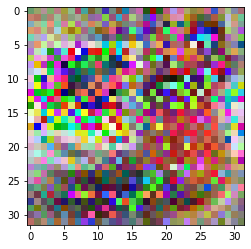

deepinversion finshed


In [ ]:
# CODICE PER CREARE LE IMMAGINI SINTETICHE

labels_of_modified = torch.zeros(0, dtype = int).to('cuda')
for label in batch:
  labels = torch.LongTensor([diz[label]]*20).to('cuda')
  labels_of_modified = torch.cat((labels_of_modified, labels), dim=0)
print('len to be created', len(labels_of_modified))
number_of_images_created = 200

#SE VOGLIO USARE COME TEACHER LA NOSTRA RETE USARE IL CODICE QUI

teacher = copy.deepcopy(fake_model)
net_teacher = resnet32(num_classes=10).to('cuda')
net_teacher.load_state_dict(teacher.state_dict())
net_teacher.eval()

#net_student = resnet32(num_classes=10).to('cuda')
net_student = resnet18().to('cuda')

#trials.eval()

inputs = torch.randn((number_of_images_created, 3, 32, 32), requires_grad=True, device='cuda', dtype=torch.float)
train_writer = None  # tensorboard writter
global_iteration = 0
di_lr = 0.05
optimizer_di = optim.Adam([inputs], lr=di_lr)
plt.imshow(tensor2im(inputs[0]))
plt.show()
print("Starting model inversion")
batch_idx = 0
inputs = get_images(net=net_teacher, bs=len(labels_of_modified), epochs=1500, idx=batch_idx, 
                  net_student=net_student, competitive_scale=10.0, l2_coeff = 3e-8, bn_reg_scale = 5.0,
                  train_writer=train_writer, use_amp=False,
                  optimizer=optimizer_di, inputs=inputs, 
                  var_scale=2.5e-5, labels=labels_of_modified) #2.5e-5
#trials.eval()
plt.imshow(tensor2im(inputs[0]))
plt.show()
print('deepinversion finshed')

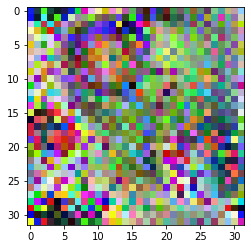

In [ ]:
plt.imshow(tensor2im(inputs.data[5]))
plt.show()

In [ ]:
#fake_diz = {0:11, 1:5, 2:62, 3:76, 4:27, 5:3, 6:96, 7:33, 8:78, 9:30}
#labels_of_modified = torch.tensor([fake_diz[c.item()] for c in labels_of_modified]).to('cuda')

inputs_data = torch.tensor(inputs, requires_grad=False).cpu()

porcoddio = torch.utils.data.TensorDataset(torch.randn(len(inputs.data), requires_grad=False).cpu(), inputs_data, labels_of_modified.cpu())
porcoddiol = DataLoader(porcoddio, batch_size = 128, shuffle=False, drop_last=False)#, num_workers=4, drop_last=False) #A SECONDA DEL BATCH

correct = 0.0
total = 0.0
model.train('False')
for _, image, label in test_loader:
  labels = torch.tensor(torch.tensor([diz[c.item()] for c in label]))
  labels = labels.to('cuda')
  image = image.to('cuda')
  outputs = model(image)
  _, preds = torch.max(outputs, dim=1)
  total += len(labels)
  correct += torch.sum(preds == labels).item()

acc = correct / total
print('accuracy', acc)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


accuracy 0.7979910714285714


In [ ]:
#PER VERIFICARE COME LA NOSTRA RETE CLASSIFICA LE IMMAGINI SINTETICHE
model.eval()

total = 200.0
correct = 0.0

#label = torch.tensor([torch.tensor(diz[c.item()]) for c in labels_of_modified]).to('cuda')
label = labels_of_modified.to('cuda')
outputs = model(inputs.data)
_, preds = torch.max(outputs, dim=1)
correct += torch.sum(preds == label).item()
#total += len(label)
acc = correct / total
print('test accuracy only syntetic exemplars', acc)

test accuracy only syntetic exemplars 0.575


In [ ]:
fake_model.eval()
total = 0.0
correct = 0.0
for  _, images, labels in porcoddiol:
  labels = torch.tensor([torch.tensor(diz[c.item()]) for c in labels])
  labels = labels.to('cuda')
  images = images.to('cuda')
  outputs = model(images)
  _, preds = torch.max(outputs, dim=1)
  total += len(labels)
  correct += torch.sum(preds == labels).item()

acc = correct / total
print('test accuracy with syntetic exemplars', acc)

test accuracy with syntetic exemplars 0.575


In [ ]:
round(666/40)

17

In [ ]:
np.concatenate(([[[[3,4], [5,6]]], [[[7,8], [9,0]]], [[[6,3], [77, 889]]]]), axis = 0)

array([[[  3,   4],
        [  5,   6]],

       [[  7,   8],
        [  9,   0]],

       [[  6,   3],
        [ 77, 889]]])

In [ ]:
torch.cat((torch.randn((3,2,2)), torch.randn((3,2,2))))

tensor([[[ 1.8066,  1.4167],
         [ 0.7844,  1.7215]],

        [[ 0.8729,  0.2184],
         [-0.1235,  1.1297]],

        [[-1.1463, -0.1637],
         [ 0.7184,  0.9206]],

        [[-0.6349,  0.1914],
         [-1.3130,  0.0624]],

        [[-0.3488, -0.2215],
         [-1.9928,  0.0610]],

        [[ 0.7669, -0.8827],
         [ 0.8948,  1.0270]]])

In [ ]:
diz